<a href="https://colab.research.google.com/github/Anjali-Kadiyala/cancerClassify/blob/main/Scotty2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

roughly 1 minute 30 sec to run all

In [1]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!cp /content/drive/Shareddrives/cancerClassify_ML@SJSU/kaggle.json /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
with ZipFile('/content/breast-histopathology-images.zip', 'r') as zipObj:
    zipObj.extractall("data")

In [5]:
from os import listdir
len(listdir('data'))

280

IDC_regular_ps50_idx5 is the same data but all the images are regularized to be 50x50

I think


In [6]:
from tqdm import tqdm

images  = []
targets = []
pids    = []


base_path = '/content/data/IDC_regular_ps50_idx5'
patients = listdir(base_path)
for pat in tqdm(patients):
    for c in [0, 1]:
        fold = f'{base_path}/{pat}/{c}/'
        imgs = listdir(fold)
        images += [fold + img for img in imgs]
        targets += [c]*len(imgs)
        pids += [pat]*len(imgs)
len(images), len(targets), len(pids)

100%|██████████| 279/279 [00:00<00:00, 1259.38it/s]


(277524, 277524, 277524)

In [7]:
import pandas as pd

df = pd.DataFrame({
    'Patient': pids,
    'Image': images,
    'Target': targets
})
df.sample(10)

,Patient,Image,Target
183608,12751,/content/data/IDC_regular_ps50_idx5/12751/0/12...,0
171423,9177,/content/data/IDC_regular_ps50_idx5/9177/1/917...,1
105259,12810,/content/data/IDC_regular_ps50_idx5/12810/0/12...,0
104889,12810,/content/data/IDC_regular_ps50_idx5/12810/0/12...,0
98053,13460,/content/data/IDC_regular_ps50_idx5/13460/0/13...,0
58535,10295,/content/data/IDC_regular_ps50_idx5/10295/0/10...,0
239354,12749,/content/data/IDC_regular_ps50_idx5/12749/1/12...,1
64598,12880,/content/data/IDC_regular_ps50_idx5/12880/0/12...,0
250538,9077,/content/data/IDC_regular_ps50_idx5/9077/1/907...,1
97481,9258,/content/data/IDC_regular_ps50_idx5/9258/0/925...,0


# Dataset Exploration

In [8]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Cancerous vs Benign samples')

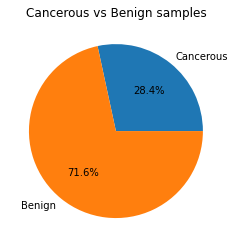

In [9]:
neg, pos = len(df[df.Target==0]), len(df[df.Target==1])
plt.pie([pos, neg], labels=["Cancerous", "Benign"], autopct='%1.1f%%')
plt.title("Cancerous vs Benign samples")

In [10]:
tmp = df[['Patient', 'Target']]
grp = tmp.groupby(by='Patient')
tmp = grp.sum()
tmp['Total'] = grp.count()['Target']
tmp.head()

,Target,Total
Patient,,
10253,70,549
10254,76,848
10255,91,272
10256,117,468
10257,208,635


In [11]:
import torchvision.transforms as T
def show_img(img):
    plt.imshow(T.ToPILImage()(img))

# Dataset

In [15]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch

class BC_Dataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.images  = []
        self.targets = []
        self.pids    = []
        base_path = root
        patients = listdir(base_path)
        for pat in tqdm(patients):
            for c in [0, 1]:
                fold = f'{base_path}/{pat}/{c}/'
                imgs = listdir(fold)
                self.images += [fold + img for img in imgs]
                self.targets += [c]*len(imgs)
                self.pids += [pat]*len(imgs)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        label = self.targets[idx]
        if torch.cuda.is_available():
            image = image.to('cuda')
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.float()/255, label

In [16]:
full_set = BC_Dataset(base_path, transform=T.Resize((50,50)))

100%|██████████| 279/279 [00:00<00:00, 1305.49it/s]


In [17]:
full_set[0]

(tensor([[[0.9608, 0.9294, 0.8588,  ..., 0.8510, 0.8510, 0.8471],
          [0.9098, 0.8902, 0.8431,  ..., 0.7922, 0.8549, 0.8588],
          [0.8314, 0.8157, 0.8392,  ..., 0.8039, 0.8196, 0.8392],
          ...,
          [0.8471, 0.8353, 0.8431,  ..., 0.8314, 0.8549, 0.8824],
          [0.8745, 0.8627, 0.8745,  ..., 0.8196, 0.8039, 0.8588],
          [0.7451, 0.8118, 0.8745,  ..., 0.9569, 0.9020, 0.8000]],
 
         [[0.9451, 0.8706, 0.6510,  ..., 0.6196, 0.5882, 0.6000],
          [0.8078, 0.7647, 0.6824,  ..., 0.5176, 0.6157, 0.5608],
          [0.5843, 0.6510, 0.6157,  ..., 0.5686, 0.5961, 0.5961],
          ...,
          [0.5608, 0.5333, 0.5020,  ..., 0.5451, 0.5961, 0.6275],
          [0.5647, 0.5647, 0.5882,  ..., 0.5686, 0.4706, 0.5137],
          [0.4706, 0.4824, 0.5490,  ..., 0.9137, 0.7843, 0.5255]],
 
         [[0.9569, 0.9137, 0.7647,  ..., 0.7373, 0.7216, 0.7255],
          [0.8667, 0.8549, 0.7804,  ..., 0.6706, 0.7451, 0.7098],
          [0.7333, 0.7725, 0.7255,  ...,

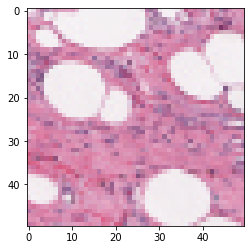

In [18]:
show_img(full_set[0][0])

In [19]:
from torch.utils.data import random_split
import torch
train_set, valid_set, test_set = random_split(
    full_set, 
    [
        int(0.7*len(full_set)), 
        int(0.2*len(full_set)), 
        len(full_set)-int(0.7*len(full_set))-int(0.2*len(full_set))], 
    generator=torch.Generator(device="cpu").manual_seed(42)
)
[len(_set) for _set in [train_set, valid_set, test_set]]

[194266, 55504, 27754]

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [21]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

train_dataloader = DataLoader(train_set, batch_size=50, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dataloader = DataLoader(test_set, batch_size=50, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

# CNN

In [22]:
from torch import nn

In [23]:
ip = torch.rand(3, 50, 50)
convo = nn.Conv2d(3, 24, 3)
rel = nn.ReLU()
pool = nn.MaxPool2d(4)
convo(ip).size(), rel(convo(ip)).size(), pool(rel(convo(ip))).size()

(torch.Size([24, 48, 48]), torch.Size([24, 48, 48]), torch.Size([24, 12, 12]))

In [24]:
stk = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
stk(ip).size()

torch.Size([64, 11, 11])

In [25]:
64*11*11

7744

In [26]:
class BC_Classifier(nn.Module):
    def __init__(self):
        super(BC_Classifier, self).__init__()
        self.convo_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*11*11, 2000),
            nn.ReLU(),
            nn.Linear(2000, 200),
            nn.ReLU(),
            nn.Linear(200, 2),
        )

    def forward(self, x):
        x = self.convo_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [27]:
model = BC_Classifier().to(device)
print(model)

BC_Classifier(
  (convo_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7744, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [28]:
X = torch.rand(5, 3, 50, 50, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0, 0, 0, 0, 0], device='cuda:0')


# Training

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-8
optimizer = torch.optim.Adam(model.parameters()) #torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.680629  [    0/194266]
loss: 0.536307  [ 5000/194266]
loss: 0.405110  [10000/194266]
loss: 0.531963  [15000/194266]
loss: 0.409221  [20000/194266]
loss: 0.529281  [25000/194266]
loss: 0.435012  [30000/194266]
loss: 0.348707  [35000/194266]
loss: 0.364193  [40000/194266]
loss: 0.444976  [45000/194266]
loss: 0.489710  [50000/194266]
loss: 0.350084  [55000/194266]
loss: 0.335820  [60000/194266]
loss: 0.355555  [65000/194266]
loss: 0.428507  [70000/194266]
loss: 0.241325  [75000/194266]
loss: 0.441017  [80000/194266]
loss: 0.372383  [85000/194266]
loss: 0.386338  [90000/194266]
loss: 0.378191  [95000/194266]
loss: 0.295804  [100000/194266]
loss: 0.426819  [105000/194266]
loss: 0.412765  [110000/194266]
loss: 0.332675  [115000/194266]
loss: 0.247232  [120000/194266]
loss: 0.284007  [125000/194266]
loss: 0.282078  [130000/194266]
loss: 0.331784  [135000/194266]
loss: 0.392136  [140000/194266]
loss: 0.363794  [145000/194266]
loss: 0.315375  [150